In [1]:
from utils.asf_parser import parse_asf
from utils.plot_skeleton import plot_skeleton
from utils.amc_parser import parse_motion_file, Motion
from utils.set_motion import set_motion, MotionFrame
from utils.skeleton import Skeleton
import matplotlib.pyplot as plt
from matplotlib.pyplot import Axes
import numpy as np
plt.rcParams['font.family'] = 'Jetbrains Mono'
plt.style.use('bmh')

In [2]:
skeleton = parse_asf("all_asfamc/subjects/22/22.asf")
motion = parse_motion_file("all_asfamc/subjects/22/22_09.amc")

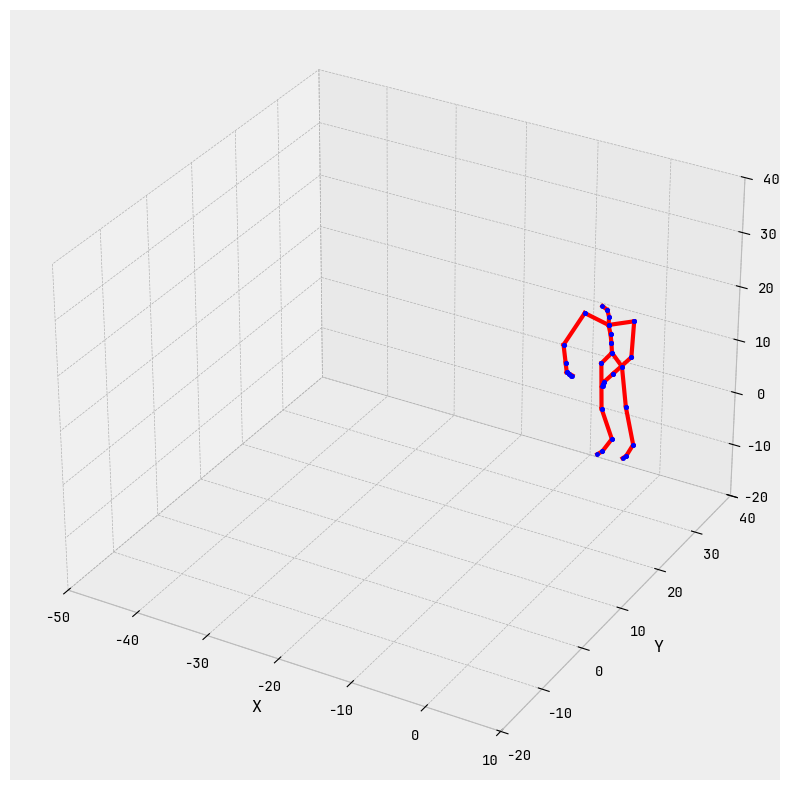

In [3]:
set_motion(skeleton, motion.frames[0])

fig = plt.figure(figsize=(10, 10))
plot_skeleton(skeleton, fig.add_subplot(111, projection='3d'))

In [4]:
max_bone_influence = 4 # influence from 1 parent bone and 3 child bones, should be padded with zeros if a bone has not parent or less than 3 children
context_window = 50 # the number of past frames to use as context
bone_feature_count = 3 # 3 for euler orientation data
shape = (max_bone_influence + 1, context_window , bone_feature_count)

def get_bone_euler_orientation(bone: str, frame: MotionFrame, skeleton: Skeleton):
    bone_motion = frame.get(bone)

    bone_data = skeleton.bone_map.get(bone)
    assert bone_data is not None
    orientation  = np.zeros(3)
    if bone_motion is None:
        return orientation
    

    if bone == "root":
        orientation[0] = bone_motion[3]
        orientation[1] = bone_motion[4]
        orientation[2] = bone_motion[5]
    else:
        for i, dof in enumerate(bone_data.dof):
            orientation[dof] = bone_motion[i]

    return np.deg2rad(orientation)


def extract_bone_features(bone: str, motion: Motion, start_index: int, skeleton: Skeleton):
    # shape = (5, 3, 20)
    bone_features = np.zeros(shape)

    bone_data = skeleton.bone_map[bone]
    assert bone_data is not None

    parent_bone = bone_data.parent

    if (parent_bone is not None):
         bone_features[0] = np.vstack([np.array(get_bone_euler_orientation(parent_bone.name, motion.frames[start_index + i], skeleton)) for i in range(context_window)])
    
    bone_features[1] = np.vstack([np.array(get_bone_euler_orientation(bone, motion.frames[start_index + i], skeleton)) for i in range(context_window)])

    for index, child in enumerate(bone_data.children):
        bone_features[2 + index] = np.vstack([np.array(get_bone_euler_orientation(child.name, motion.frames[start_index + i], skeleton)) for i in range(context_window)])
    return bone_features 



In [5]:
extract_bone_features("rhumerus", motion, 0, skeleton).shape

(5, 50, 3)

Couple of things to note about the data

* The motion is captured at very high frame rates, 60 - 120 fps. This means that to observe a significant change, one would need to obvserve a lot of frames, which can be computationally expensive. One way to resolve this is to use a lower frame rate, say 4 fps. So, we would downsample the data across time domain using rolling averages to get to the target fps. For example, if initially we have 120fps, we would use a window size of 120 / 4 frames to get to 4 fps. This would make the data more manageable and would still capture the motion.



In [6]:
def add_motion_frame(dst: MotionFrame, src: MotionFrame):
    for key in src.keys():
        dst[key] = [d + s for d, s in zip(dst[key], src[key])]

def divide_motion_frame(dst: MotionFrame, divisor: int):
    for key in dst.keys():
        dst[key] = [d / divisor for d in dst[key]]

In [7]:
def blank_motion_frame(sample_frame: MotionFrame) -> MotionFrame:
    return {key: [0] * len(sample_frame[key])    for key in sample_frame.keys()}

In [8]:
def downsample_motion(raw_motion: Motion, target_frame_rate: int, use_average: bool=True) -> Motion:
    assert target_frame_rate > 0 and target_frame_rate <= raw_motion.frame_rate
    downsampled_motion = Motion()
    downsampled_motion.frame_rate = target_frame_rate
    
    downsample_factor = raw_motion.frame_rate // target_frame_rate
    
    for start_frame_index in range(0, len(raw_motion.frames), downsample_factor):
        motion_frame = blank_motion_frame(raw_motion.frames[start_frame_index])

        if use_average:
            total_frames = 0
            for frame_index in range(start_frame_index, min(start_frame_index + downsample_factor, len(raw_motion.frames))):
                total_frames += 1
                add_motion_frame(motion_frame, raw_motion.frames[frame_index])
                pass
            divide_motion_frame(motion_frame, total_frames)
        else:
            add_motion_frame(motion_frame, raw_motion.frames[start_frame_index])
        downsampled_motion.frames.append(motion_frame)
        pass

    return downsampled_motion


In [9]:
def smooth_motion(raw_motion: Motion, window_size: int) -> Motion:
    smoothed_motion = Motion()
    smoothed_motion.frame_rate = raw_motion.frame_rate

    for motion_frame_index, motion_frame in enumerate(raw_motion.frames):
        smoothed_frame = blank_motion_frame(motion_frame)
        total_frame_count = 0
        for frame in raw_motion.frames[max(0, motion_frame_index - window_size): motion_frame_index + 1]:
            total_frame_count += 1
            add_motion_frame(smoothed_frame, frame)
        divide_motion_frame(smoothed_frame, total_frame_count)
        smoothed_motion.frames.append(smoothed_frame)
    return smoothed_motion


In [10]:
def plot_bone_motion_graph(bone_name: str, motion_frames: list[MotionFrame], skeleton: Skeleton, ax: Axes):
    plot_data = [[], [], []] # rx, ry, rz
    for frame_index in motion_frames:
        bone_motion = frame_index.get(bone_name)
        bone_data = skeleton.bone_map.get(bone_name)

        assert bone_data is not None
        
        if bone_motion is None:
            break

        if bone_name == "root":
            for i, rot in enumerate(bone_motion[3:]):
                plot_data[i].append(rot)
        else:
            for i, dof in enumerate(bone_data.dof):
                plot_data[dof].append(bone_motion[i])

    ax.plot(range(len(plot_data[0])) ,plot_data[0], label="rx", color="red", linewidth=1)
    ax.plot(range(len(plot_data[1])) ,plot_data[1], label="ry", color="green", linewidth=1)
    ax.plot(range(len(plot_data[2])) ,plot_data[2], label="rz", color="blue", linewidth=1)
    ax.set_title('Motion Graph for ' + bone_name, fontsize=10)
    ax.set_xlabel('Frame Number', fontsize=9)
    ax.set_ylabel('Motion Value (Degrees)', fontsize=9)
    ax.legend()
    ax.grid(True)
    

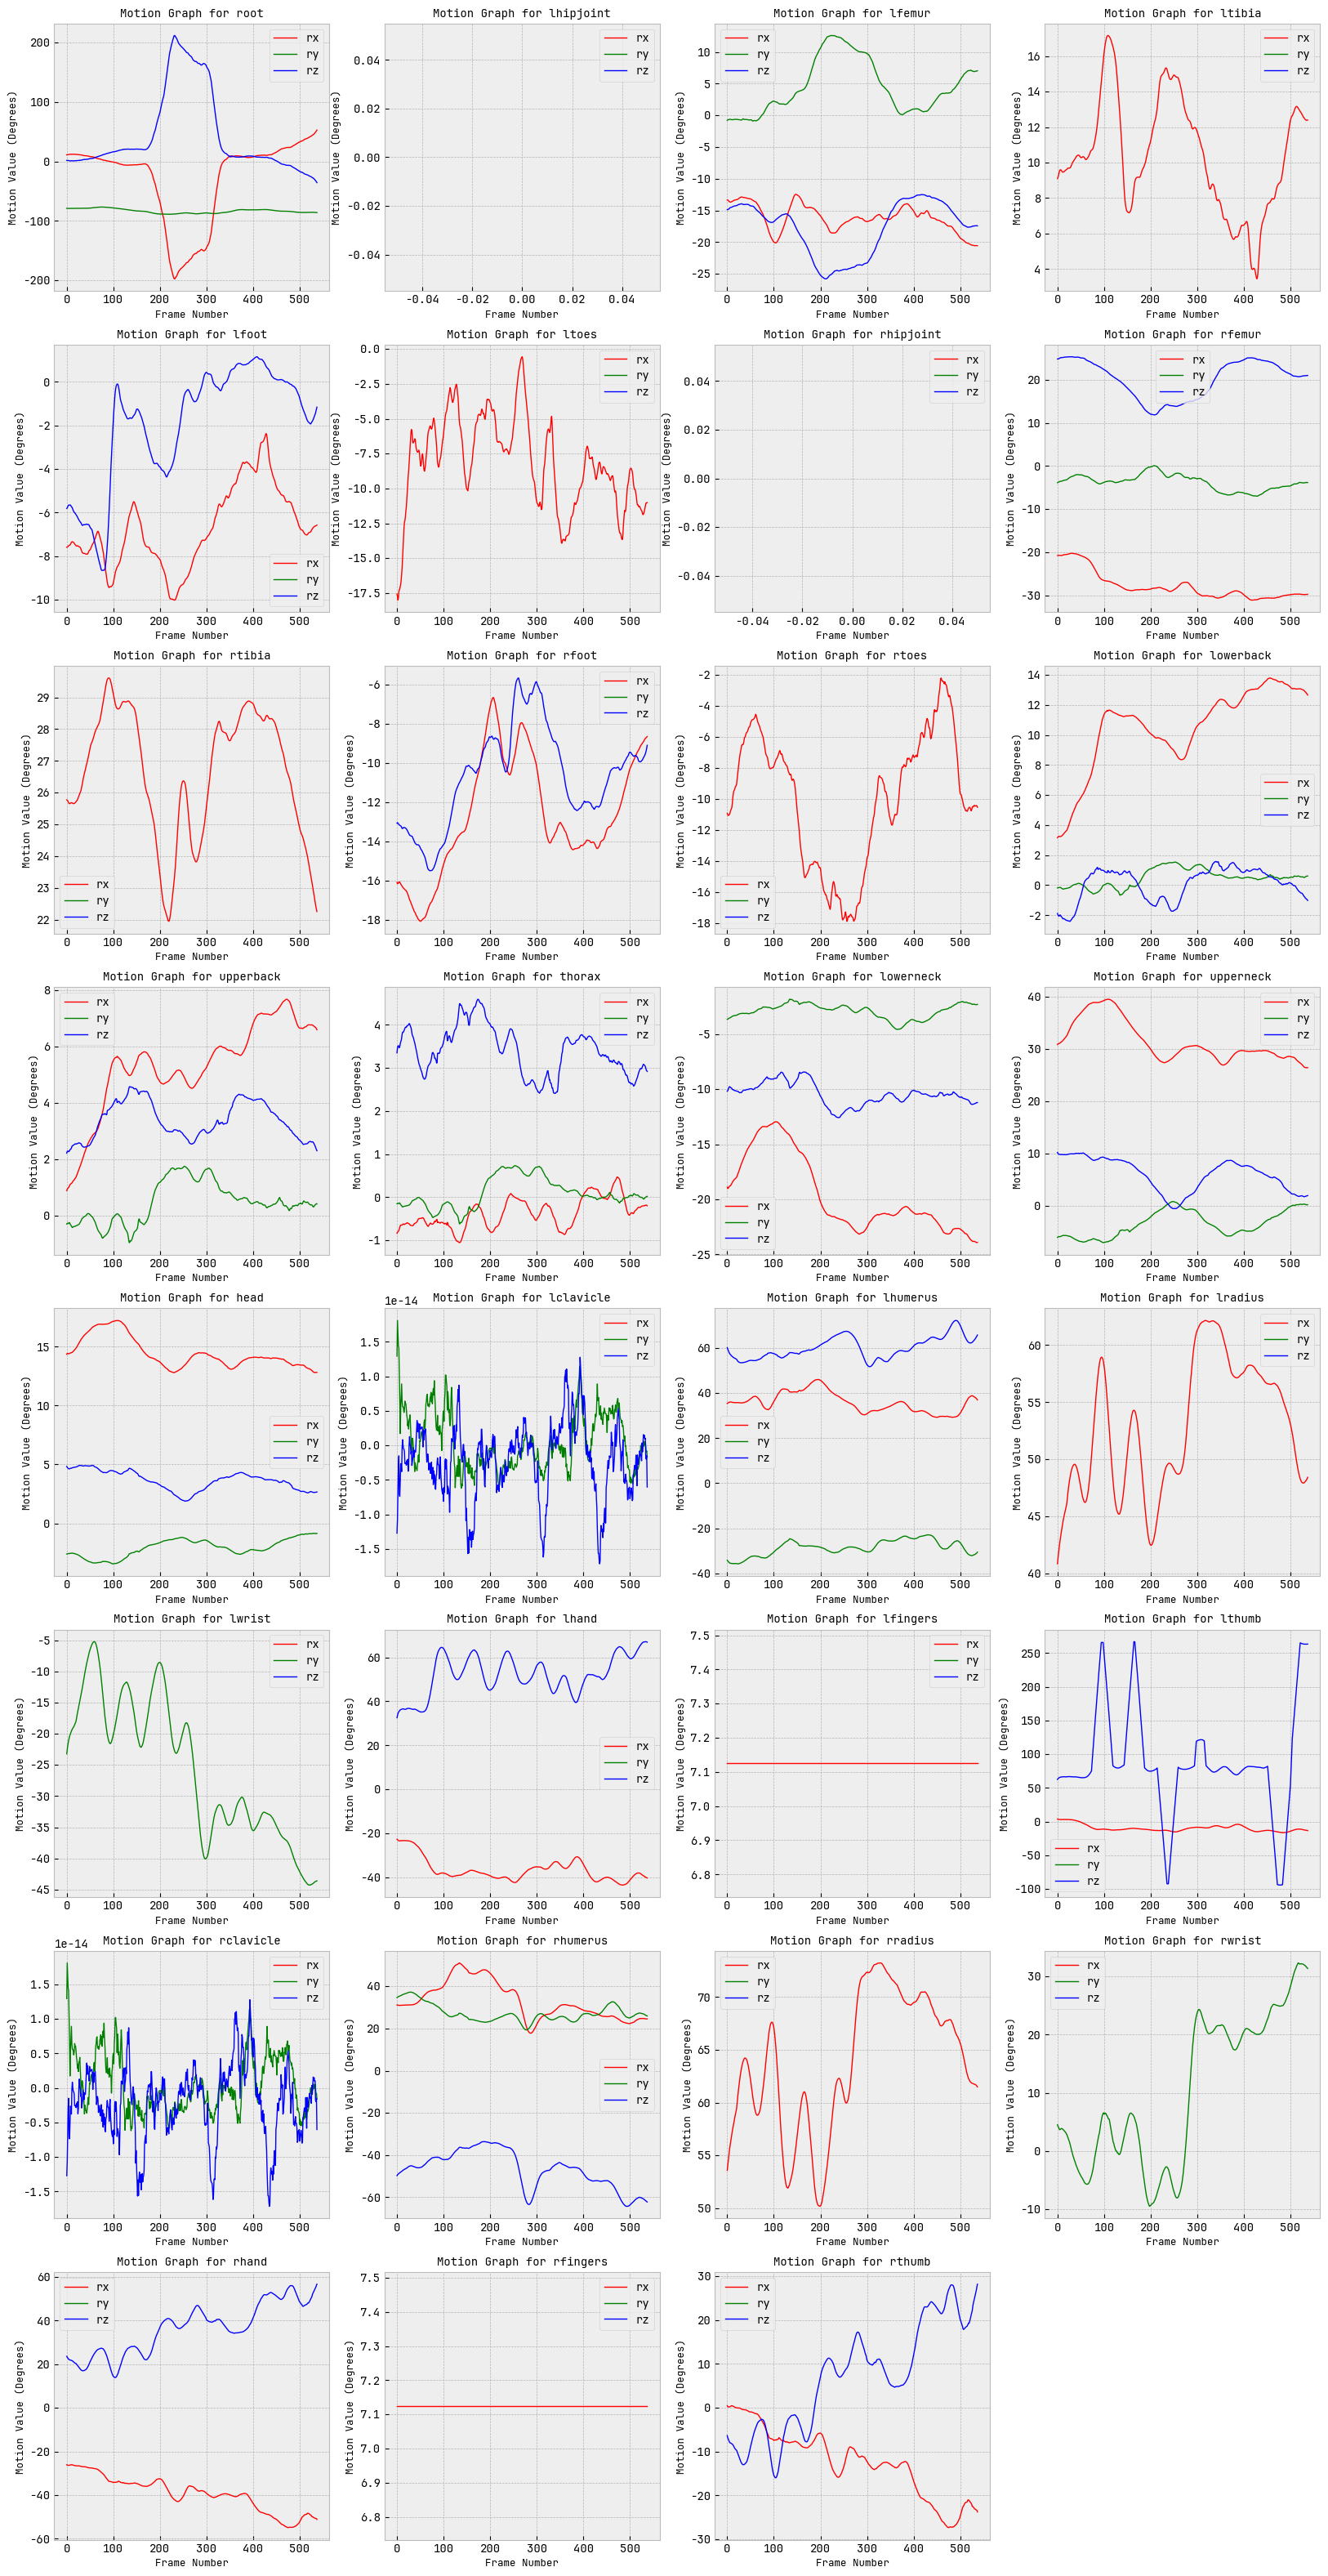

In [11]:

smoothed_motion = smooth_motion(motion, 20)
downsampled_motion = downsample_motion(smoothed_motion, 15, use_average=False)
bone_name = list(skeleton.bone_map.keys())[4]

fig = plt.figure(figsize=(20, 40))

for i, bone_name in enumerate(list(skeleton.bone_map.keys())):
    ax = fig.add_subplot(8, 4, i + 1)
    plot_bone_motion_graph(bone_name, smoothed_motion.frames, skeleton, ax)

plt.show()

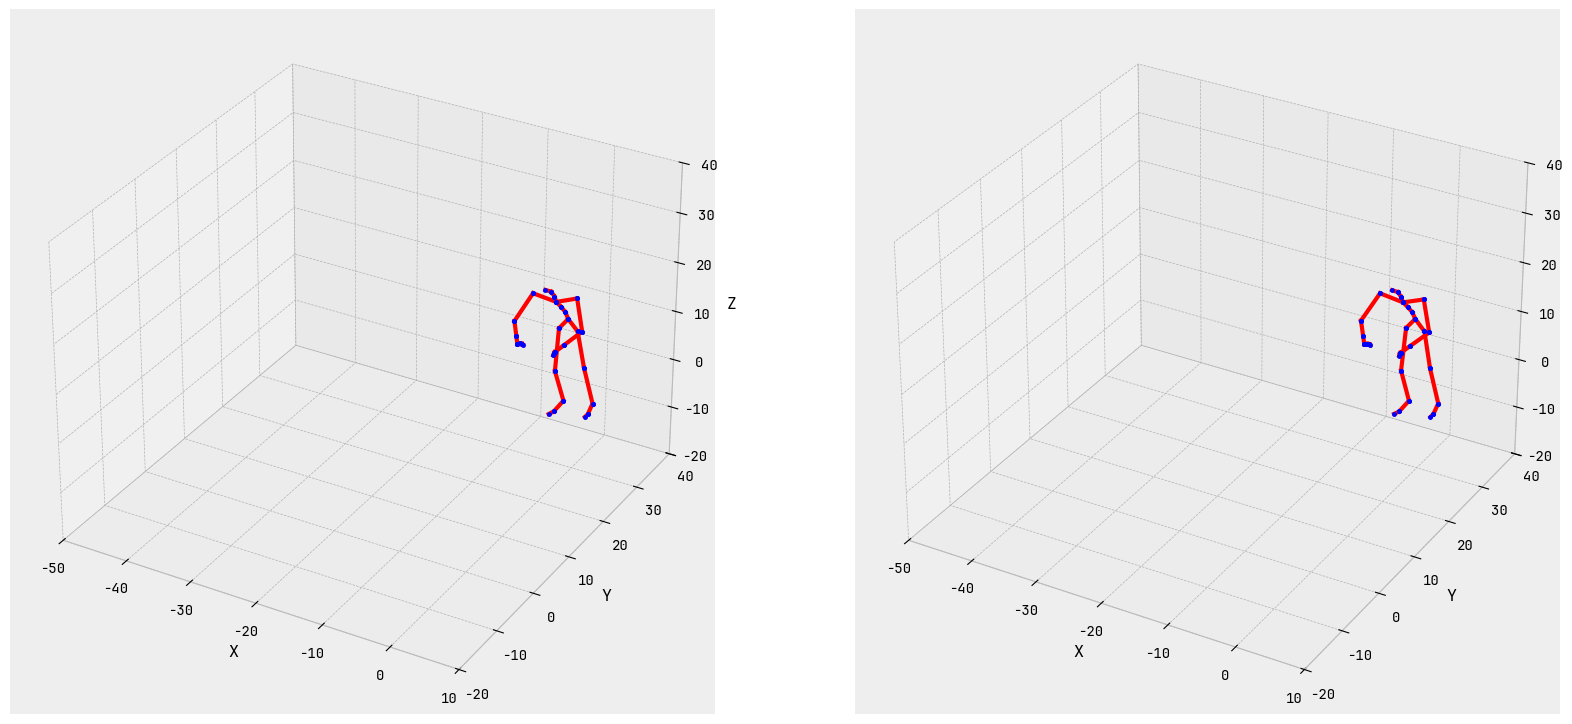

In [12]:
fig = plt.figure(figsize=(20, 40))
time = 3 #s
set_motion(skeleton, motion.frames[int(motion.frame_rate * time)])
plot_skeleton(skeleton, fig.add_subplot(121, projection='3d'))
set_motion(skeleton, smoothed_motion.frames[int(smoothed_motion.frame_rate * time)])
plot_skeleton(skeleton, fig.add_subplot(122, projection='3d'))

plt.show()

tensor([[[0.5557, 0.0317, 0.3065],
         [0.9432, 0.4336, 0.8818]]], device='cuda:0')